#  <center> <u>Investment and Trading:</u> </center> <center>Stock Predictor</center>

# <u>Definition</u>

### Project Overview

The stock market is a collection of buyers and sellers of fractions of company ownership. Buyers and sellers can take a variety of forms from individuals to investment firms to funds. Their goal is to understand how to make more profitable decisions with their investments. Copious data is available in the form of historical prices. These prices will be used to generate training data for machine learning algorithms.

The endeavor of this project will be to provide return predictions for investments over a user defined period from the present day.

Data used in this project is retrieved from the Yahoo Finance API provided through the `pandas` library. Historical data including the information of concern, adjusted closing prices, are retrieved using a company symbol, an all uppercase group of characters representing how the company is referred to in the market ("AAPL" for Apple, "ABC" for Google, "IBM" for IBM). The historical adjusted closing prices are requested for all trading days in the past year up to the day the program is run as specified in the project `README.md` file.

### Problem Statement

Accurate predictions of future stock returns provide the opportunity to make profitable and responsible investments. Stock price movements, increases and decreases in stock value, are known to be difficult to predict. Stock prices are subject to a lot of context created by participants in the stock market. While saturated with noise, there is still information that can be exploited to make more responsible market strategies.

### Metrics

The metrics used to measure the performance of the models will be Root Mean Squared Error (RMSE), Mean Average Percentage Error (MAPE), and Correlation. 

RMSE makes sense to use in most contexts because it gives a scale of the regression error in the same units as the prediction itself. MAPE, on the other hand, makes sense to use when the outcome in question is the future stock price and not the return. MAPE gives an estimate of the error as a percentage of the overall price of a stock. Since the outcome this project will focus on is investment return (future price / present price - 1) which is normally on a scale from -1 to +1, this project will display RMSE for aesthetic purposes. In other words, RMSE displays a less intimidating view of the error.

Correlation is also displayed to show how well the predictions trend with the true value of the returns. The benchmark for this is set in the analysis section by analyzing how well the current price correlates with future results.

# <u>Analysis</u>

### Data Exploration

The complex nature of presenting this data is that trends in the stock market are constantly changing. In this project, a variety of Company symbols will be used to display how the analysis was conducted. The figure below is an example of how random the market returns seem.

In [54]:
from dataset_construction import create_input, create_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
ibm = create_input("IBM")
ibm_future_prices = create_output("IBM", use_prices=True)
ibm_future_returns = create_output("IBM", use_prices=False)
ibm_future_prices.columns = ["Future_IBM"]
ibm_future_returns.columns = ["Returns_IBM"]

ibm_price_returns_df = ibm.join(ibm_future_prices).join(ibm_future_returns)
num_days = ibm_price_returns_df.shape[0]
print ibm_price_returns_df.iloc[:6]
print
print "There are {} days/observations in the data.".format(ibm_price_returns_df.shape[0])
print "{} or {:.2f}% of those days observe a 5 day future return ABOVE zero.".format(
    ibm_price_returns_df[ibm_price_returns_df.Returns_IBM>0.0].shape[0],
    ibm_price_returns_df[ibm_price_returns_df.Returns_IBM>0.0].shape[0]/float(num_days)*100.)
print "{} or {:.2f}% of those days observe a 5 day future return EQUAL TO or BELOW zero.".format(
    ibm_price_returns_df[ibm_price_returns_df.Returns_IBM<=0.0].shape[0],
    ibm_price_returns_df[ibm_price_returns_df.Returns_IBM<=0.0].shape[0]/float(num_days)*100.)
print "{} of those days observe a 5 day future return that is not a number (eg. NaN).".format(
    ibm_price_returns_df[np.isnan(ibm_price_returns_df.Returns_IBM)].shape[0])
print "The average 5 day future return for all days in this dataset is {:.4f} with a standard deviation of {:.4f}.".format(
    ibm_price_returns_df.Returns_IBM.mean(), ibm_price_returns_df.Returns_IBM.std()
)

            AdjClose_IBM  Future_IBM  Returns_IBM
Date                                             
2015-06-08    159.275180  160.161432     0.005564
2015-06-09    159.602705  160.720159     0.007001
2015-06-10    162.723864  161.038056    -0.010360
2015-06-11    162.589000  162.078442    -0.003140
2015-06-12    160.864666  160.864666     0.000000
2015-06-15    160.161432  161.577512     0.008842

There are 251 days/observations in the data.
121 or 48.21% of those days observe a 5 day future return ABOVE zero.
125 or 49.80% of those days observe a 5 day future return EQUAL TO or BELOW zero.
5 of those days observe a 5 day future return that is not a number (eg. NaN).
The average 5 day future return for all days in this dataset is -0.0005 with a standard deviation of 0.0322.


### Exploratory Visualization

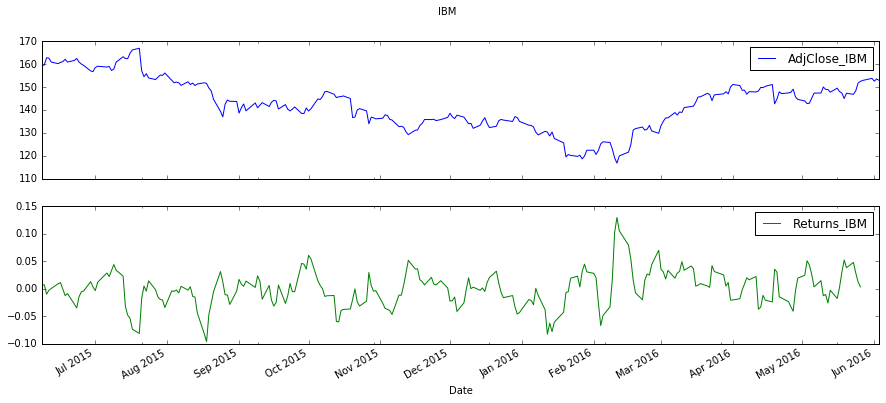

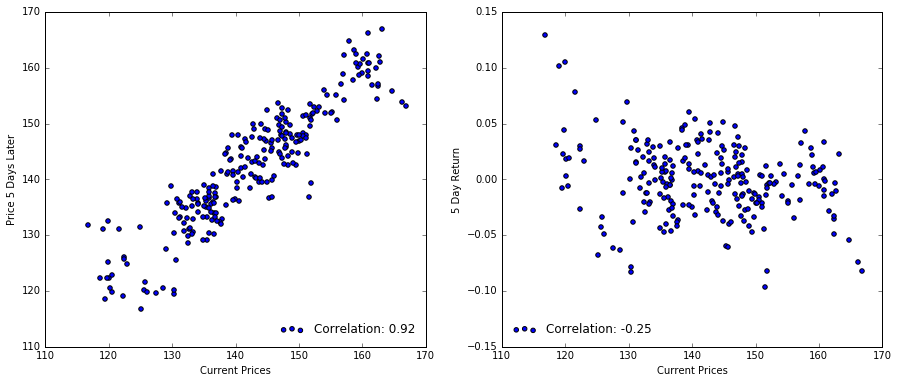

In [3]:
ibm.join(ibm_future_returns).plot(subplots=True,figsize=(15,6), title="IBM")

prices_corr = ibm.join(ibm_future_prices).corr()["AdjClose_IBM"]["Future_IBM"]
returns_corr = ibm.join(ibm_future_returns).corr()["AdjClose_IBM"]["Returns_IBM"]

f, axarr = plt.subplots(1,2, figsize=(15,6))
axarr[0].scatter(ibm,ibm_future_prices, label="Correlation: {}".format(round(prices_corr,2)))
axarr[0].set_xlabel('Current Prices')
axarr[0].set_ylabel('Price 5 Days Later')
axarr[0].legend(loc="lower right", frameon=False)
axarr[1].scatter(ibm,ibm_future_returns, label="Correlation: {}".format(round(returns_corr,2)))
axarr[1].set_xlabel('Current Prices')
axarr[1].set_ylabel('5 Day Return')
axarr[1].legend(loc="lower left", frameon=False)

plt.show()

When prices are low, prices 5 days later are likely to remain low by comparison. On the other hand, there is a moderate negative correlation between current price and 5 day returns. This implies that when prices are low, a positive return would be expected, while when prices are high, a negative return is somewhate more likely.

### Algorithms and Techniques

A variety of indicators are used to analyze the movement of prices in the market. This section will discuss some of the indicators used and how they were tested to determine which would be most effective. 

The list of indicators tested were:
* Window based Indicators:
    * N-Day Bollinger Value
        - _(Price[ t ] - N-day Moving Average) / ( 2 * N-day Standard Deviation of the Price )_
    * Exponential Moving Average (EMA)
        - _(Price[ t ] - EMA[ t-1 ]) * (2/(N+1)) + EMA[ t-1 ]_
    * N-day Simple Moving Average (SMA)
        - Average( _Price[ t-N ] to Price[ t ]_ )
    * N-day Momentum
        - _Price[ t ] / Price[ t-N ] - 1_
    * Relative Strength Index (RSI)
        - RSI = _100 - 100/(1+RS)_
        - RS = _N-day Average Gain / N-day Average Loss_
    * Volatility
        - N-day Standard Deviation of the Price 
* One non-window based indicator:
    * Weekdays
        - Is it Monday? [0 or 1]
        - Is it Tuesday? [0 or 1], 
        - etc.

Every window indicator was analyzed for varying window size from a one-day window to a thirty-day window. 

For every member of the S&P 500 list found in `spylist.csv`:
1) A dataset was created with the specified indicator and specified window.
2) The dataset was split into training and testing data.
3) A linear regression model was trained using training data.
4) The linear regression model predictions were compared the test data.
5) Test error for the indicator was added to a running total over the S&P 500 list.
6) Test errors were sorted to find the best performing indicator window.

The top three performing windows for each indicator were added to another list. All combinations up to a size of 4 indicators were then tested in the same way against the above S&P500 to determine the best set of indicators.

### Benchmark

There are a few benchmarks that this project will endeavor to beat. The first is to achieve a better test root mean squared error than predicting zero. This benchmark is essentially the equivalent of the standard deviation of the returns considering the average is essentially zero. Returns are well known to average out to 0 over short periods. Short term returns are known to be very noisy.

# <u>Methodology</u>

### Data Preprocessing

With regard to abnormalities in the data, there were not many. Occasionally, there will be gaps in Adjusted Closing data from one date to another. It is common practice to simply feed the last observed price forward to a date where there is data. That is one of the many functionalities of the Pandas library in python, specifically `DataFrame.bfill()` and `DataFrame.ffill()`.

Other than the `NaN` values discussed above, there were some that were produced by the indicators developed in this project along with in the construction of the output data. Some indicators were constructed from a defined number of trading days into the past. This meant that for some days not all the information was available to create the indicator and `NaN` values were produced. These rows were simply eliminated using `DataFrame.dropna()`.

In [44]:
# Creates input data with a 4 day window bollinger value indicator
from indicators.Bollinger import Bollinger
df = create_input("IBM", indicators=[Bollinger(4)])
print df.iloc[:6]

            AdjClose_IBM  Bollinger_4_AdjClose_IBM
Date                                              
2015-06-08    159.275180                       NaN
2015-06-09    159.602705                       NaN
2015-06-10    162.723864                       NaN
2015-06-11    162.589000                  0.413611
2015-06-12    160.864666                 -0.194547
2015-06-15    160.161432                 -0.559678


In [45]:
print df.iloc[:6].dropna()

            AdjClose_IBM  Bollinger_4_AdjClose_IBM
Date                                              
2015-06-11    162.589000                  0.413611
2015-06-12    160.864666                 -0.194547
2015-06-15    160.161432                 -0.559678


The above data shows features that are on largely different scales. To some machine learning algorithms, the size of different features will matter. Subsequently, the data was normalized using mean normalization. The normalized data is shown below.

In [48]:
df = (df-df.mean())/ df.std()
print df.iloc[:6].dropna()

            AdjClose_IBM  Bollinger_4_AdjClose_IBM
Date                                              
2015-06-11      1.819830                  0.825140
2015-06-12      1.662760                 -0.442403
2015-06-15      1.598702                 -1.203421


In [49]:
# Creates output data of 3 day future returns
df_output = create_output("IBM",horizon=3)
print df_output.iloc[-7:]

               y_IBM
Date                
2016-05-25  0.013514
2016-05-26  0.000459
2016-05-27  0.004318
2016-05-31 -0.005529
2016-06-01       NaN
2016-06-02       NaN
2016-06-03       NaN


In [50]:
print df_output.iloc[-7:].dropna()

               y_IBM
Date                
2016-05-25  0.013514
2016-05-26  0.000459
2016-05-27  0.004318
2016-05-31 -0.005529


Output data was not normalized.

### Implementation

Separating data into training and test sets was completed using the earlier data to train and the later data to test. Training and test data cannot be randomly selected because it would incur a _look-ahead bias_, which simply means that the model would have access to information that it normally would not have access.

For this reason, data was split using the first 80% of the data for training, and the last 20% for testing.

### Refinement

# <u>Results</u>

### Model Evaluation and Validation

In [140]:
from predict_future import predict_spy_future

In [141]:
# Display results ordered by test error (RMSE)
print predict_spy_future(horizon=5)

           Return_Date Symbol  Return(%)  Test_Error(RMSE)  Benchmark_0(RMSE)  \
Date                                                                            
2016-06-03  2016-06-10    ARG   0.000589          0.002927           0.001755   
2016-06-03  2016-06-10     TE   0.001541          0.003020           0.001435   
2016-06-03  2016-06-10    GAS  -0.002900          0.005149           0.004519   
2016-06-03  2016-06-10    JNJ   0.001311          0.009427           0.009253   
2016-06-03  2016-06-10     MA  -0.003306          0.009655           0.010806   
2016-06-03  2016-06-10    UPS  -0.005563          0.012148           0.013969   
2016-06-03  2016-06-10    OMC  -0.006095          0.012545           0.010864   
2016-06-03  2016-06-10    HON  -0.010738          0.012739           0.010151   
2016-06-03  2016-06-10   CPGX  -0.013680          0.013563           0.003924   
2016-06-03  2016-06-10    HIG   0.006201          0.013577           0.014869   

            Test_Correlatio

Averages
Unnamed: 0           251.500000
Return(%)             -0.005231
Test_Error(RMSE)       0.036243
Benchmark_0(RMSE)      0.033921
Test_Correlation       0.338858
dtype: float64

Average difference
0.00232208670918

Medians
Unnamed: 0           251.500000
Return(%)             -0.005646
Test_Error(RMSE)       0.030044
Benchmark_0(RMSE)      0.029029
Test_Correlation       0.341631
dtype: float64

Standard Deviations
Unnamed: 0           145.059183
Return(%)              0.016996
Test_Error(RMSE)       0.021471
Benchmark_0(RMSE)      0.020676
Test_Correlation       0.248611
dtype: float64


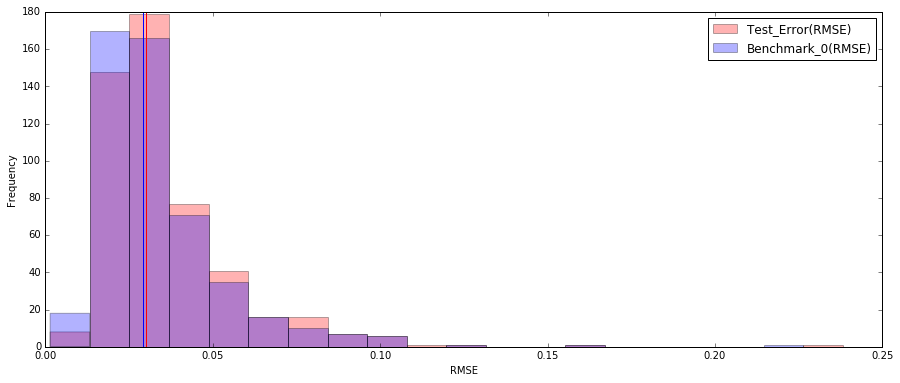

In [142]:
predicted_returns_results = pd.read_csv("return_results.csv", index_col="Date")
print "Averages"
print predicted_returns_results.mean(axis=0)
print
print "Average difference"
print np.mean(predicted_returns_results[["Test_Error(RMSE)"]].values - predicted_returns_results[["Benchmark_0(RMSE)"]].values)
print
print "Medians"
print predicted_returns_results.median(axis=0)
print
print "Standard Deviations"
print predicted_returns_results.std(axis=0)
predicted_returns_results[["Test_Error(RMSE)","Benchmark_0(RMSE)"]].plot.hist(color=["r","b"],bins=20,alpha=0.3,figsize=(15,6))
plt.axvline(predicted_returns_results.median(axis=0)[["Test_Error(RMSE)"]].values, color="r")
plt.axvline(predicted_returns_results.median(axis=0)[["Benchmark_0(RMSE)"]].values, color="b")
plt.xlabel("RMSE")
plt.show()

In [143]:
print predict_spy_future(horizon=5, use_prices=True)

           Future_Date Symbol  Future_Price($)  Test_Error(MAPE)  \
Date                                                               
2016-06-03  2016-06-10     TE        27.547510          0.001669   
2016-06-03  2016-06-10    ARG       143.056825          0.001785   
2016-06-03  2016-06-10    GAS        65.583132          0.003258   
2016-06-03  2016-06-10    JNJ       115.141605          0.007425   
2016-06-03  2016-06-10     MA        95.679445          0.007838   
2016-06-03  2016-06-10    OMC        81.571225          0.008593   
2016-06-03  2016-06-10    HON       113.829812          0.009696   
2016-06-03  2016-06-10    UPS       102.564879          0.009808   
2016-06-03  2016-06-10   SNDK        75.715547          0.009876   
2016-06-03  2016-06-10    COL        86.975462          0.010367   

            Benchmark_Last_Price(MAPE)  Test_Correlation  
Date                                                      
2016-06-03                    0.001057          0.083445  
2016-0

Averages
Unnamed: 0                    251.500000
Future_Price($)                83.896369
Test_Error(MAPE)                0.029813
Benchmark_Last_Price(MAPE)      0.027405
Test_Correlation                0.257287
dtype: float64

Average difference
0.00240824775788

Medians
Unnamed: 0                    251.500000
Future_Price($)                64.032309
Test_Error(MAPE)                0.024436
Benchmark_Last_Price(MAPE)      0.023478
Test_Correlation                0.238226
dtype: float64

Standard Deviations
Unnamed: 0                    145.059183
Future_Price($)               100.765771
Test_Error(MAPE)                0.020259
Benchmark_Last_Price(MAPE)      0.017794
Test_Correlation                0.334447
dtype: float64


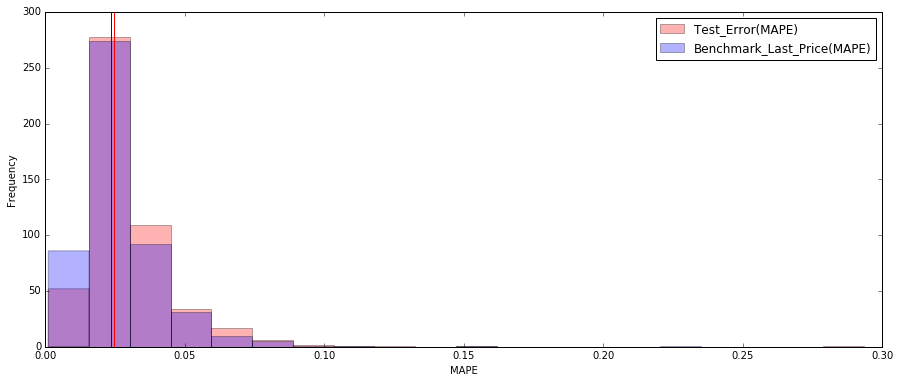

In [144]:
predicted_prices_results = pd.read_csv("price_results.csv", index_col="Date")
print "Averages"
print predicted_prices_results.mean(axis=0)
print
print "Average difference"
print np.mean(predicted_prices_results[["Test_Error(MAPE)"]].values - predicted_prices_results[["Benchmark_Last_Price(MAPE)"]].values)
print
print "Medians"
print predicted_prices_results.median(axis=0)
print
print "Standard Deviations"
print predicted_prices_results.std(axis=0)
predicted_prices_results[["Test_Error(MAPE)","Benchmark_Last_Price(MAPE)"]].plot.hist(color=["r","b"], bins=20, alpha=0.3,figsize=(15,6))
plt.axvline(predicted_prices_results.median(axis=0)[["Test_Error(MAPE)"]].values, color="r")
plt.axvline(predicted_prices_results.median(axis=0)[["Benchmark_Last_Price(MAPE)"]].values, color="b")
plt.xlabel("MAPE")
plt.show()

In [147]:
bench_list, error_list = [], []
bench_std_list, error_std_list = [], []
weeks = range(1,16)
for week in weeks:
    predict_spy_future(horizon=5*week)
    test = pd.read_csv("return_results.csv", index_col="Date")
    error_list.append(test.mean(axis=0)[["Test_Error(RMSE)"]])
    bench_list.append(test.mean(axis=0)[["Benchmark_0(RMSE)"]])
    error_std_list.append(test.std(axis=0)[["Test_Error(RMSE)"]])
    bench_std_list.append(test.std(axis=0)[["Benchmark_0(RMSE)"]])

In [148]:
error_upper_band = [mn + 3*std for mn, std in zip(error_list, error_std_list)]
bench_upper_band = [mn + 3*std for mn, std in zip(bench_list, bench_std_list)]

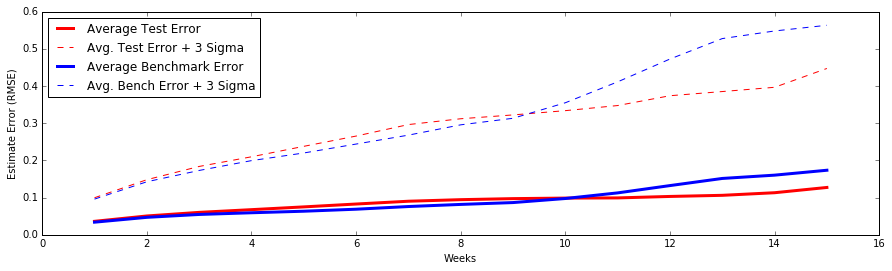

In [149]:
fig, ax = plt.subplots(figsize=(15,4))
#
test_error_plot, = plt.plot(weeks, error_list, 'r', lw=3)
test_error_upper_plot, = plt.plot(weeks, error_upper_band, 'r--')
bench_error_plot, = plt.plot(weeks, bench_list, 'b', lw=3)
bench_error_upper_plot, = plt.plot(weeks, bench_upper_band, 'b--')
plt.legend([test_error_plot, test_error_upper_plot, bench_error_plot, bench_error_upper_plot], 
           ["Average Test Error", "Avg. Test Error + 3 Sigma", "Average Benchmark Error", "Avg. Bench Error + 3 Sigma"], 
           loc="upper left")
plt.xlabel("Weeks")
plt.ylabel("Estimate Error (RMSE)")

plt.show()

### Justification

The results, as shown in the previous section, are comparable to the benchmark over a number of weeks. Unfortunately, when the test error beats the benchmark, the overall error is too substantial to consider as a feasible predictor of returns.

# <u>Conclusion</u>

### Free Form Visualization

### Reflection

### Improvement

There are a myriad of improvements that can be made to this product. There are hundreds, if not thousands, of technical indicators used in inter- and intraday trading. There is continuous analysis and debate over which indicators are most effective, just as there is the same analysis and debate over which models are most effective in this realm.